In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
#         break
# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mars-spec-train/train_labels.csv
/kaggle/input/mars-spec-train/train_features/S0459.csv


## 1. Data Description 
<ul> 
<li>there are 809 training examples</li>
<li>each of them is dataframe with time, mass , and intensity</li>
<li>dataframe lenghts are variable</li>
</ul>


In [25]:
# for processing numbers and files csv
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.utils import class_weight


# model related
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import tensorflow as tf


In [2]:
# metadata = pd.read_csv('/kaggle/input/mars-spec-train/metadata.csv').fillna(0)
# train_labels = pd.read_csv('/kaggle/input/mars-spec-train/train_labels.csv')
metadata = pd.read_csv('metadata.csv').fillna(0)
train_labels = pd.read_csv('train_labels.csv')

In [3]:
metadata.head(2)

,sample_id,split,derivatized,features_path,features_md5_hash
0,S0000,train,0.0,train_features/S0000.csv,52ec6d6f8372500ab4e069b5fbdae6f9
1,S0001,train,0.0,train_features/S0001.csv,348f90baed8a8189bf0d4c7b9ed9f965


In [4]:
train_labels.head(2)

,sample_id,aromatic,hydrocarbon,carboxylic_acid,nitrogen_bearing_compound,chlorine_bearing_compound,sulfur_bearing_compound,alcohol,other_oxygen_bearing_compound,mineral
0,S0000,0,0,0,0,0,0,0,0,1
1,S0001,0,0,0,0,0,0,0,0,0


## 2. Preprocessing and Feature extraction
<ul>
<li>mass values are grouped into values seperated by 0.50 </li>
<li>time values are grouped into values seperated by 0.02 </li>
<li>Time * Mass matrix (2650,1350) with Intensity values </li>
</ul>

In [5]:
# constants
num_mass_values = 1350
num_time_values = 2650
matrix_shape = (num_time_values, num_mass_values)


In [11]:

# Function to create the Time X Mass matrix for a single data sample
def create_matrix(id, lab = None ):
    
    sample_id, split, derivate, path, _ = metadata.iloc[id]
    path = path
    # path = '/kaggle/input/mars-spec-train/'+ path
    data = pd.read_csv(path)

    label = None
    if (split == 'train'):
        label = train_labels.iloc[id].values[lab]
    data.time = (data.time*50).round()
    data.mass = (data.mass*2).round()
    data.time = data.time.astype(int)
    data.mass = data.mass.astype(int)
    
    data.intensity = MinMaxScaler().fit_transform(data.intensity.values.reshape(-1, 1))
    
    matrix = np.zeros(matrix_shape)
    matrix[data['time'],data['mass']] = data['intensity']

    return matrix , label


In [28]:
sample_matrix, sample_label= create_matrix(np.random.randint(809),1) ## 0.2 second # max = 1120
sample_matrix[0:100, 100:200],sample_label

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 0)

## 3. Data Generation
<ul>
<li>Storing data matrix is costly</li>
<li>data is generated in batches</li>
</ul>


In [29]:
training_data = range(809)  # Load your training data
train_data, val_data = train_test_split(training_data, test_size=0.2, random_state=42)


In [18]:
class DataGenerator(Sequence):
    
    def __init__(self, data, batch_size, lab):
        self.data = data
        self.batch_size = batch_size
        self.lab = lab
    def __len__(self):
        return len(self.data) // self.batch_size

    def __getitem__(self, idx):        
        
        low = idx * self.batch_size
        high = min(low + self.batch_size, len(self.data))
        batch_x = []
        batch_y = []

        for i,data_sample in enumerate(self.data[low:high]):
            processed_sample, processed_label = self.preprocess_data(data_sample)
            batch_x.append(processed_sample)
            batch_y.append(processed_label)
        return np.array(batch_x), np.array(batch_y)

    def preprocess_data(self, data_sample):
        matrix, label = create_matrix(data_sample, self.lab)
        return matrix , label

## 4. Models
<ul>
<li>9 seperate model for each class</li>
<li>each model have balanced class weights</li>

<li>convolutional layers </li>
<li>pooling layers (max pooling) </li>
<li>fully connected layers</li>
<li>sigmoid layer</li>
<li>output positive label probability</li>
</ul>

In [30]:
label_names = [col for col in train_labels.columns[1:]]

### model1 - Aromatic 

In [37]:
label_number = 1
model1 = Sequential()
model1.add(Conv2D(8, kernel_size=(10, 10),strides = (2,2), activation='relu', input_shape=(2650, 1350, 1)))
model1.add(MaxPooling2D(pool_size=(50, 25)))
model1.add(Flatten())
model1.add(Dense(32, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=["AUC"])
model1.summary()

batch_size = 16
num_epochs = 32

train_data_generator = DataGenerator(train_data, batch_size, label_number)
val_data_generator = DataGenerator(val_data, batch_size, label_number)


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 1321, 671, 8)      808       
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 26, 26, 8)         0         
 ng2D)                                                           
                                                                 
 flatten_15 (Flatten)        (None, 5408)              0         
                                                                 
 dense_38 (Dense)            (None, 32)                173088    
                                                                 
 dense_39 (Dense)            (None, 1)                 33        
                                                                 
Total params: 173929 (679.41 KB)
Trainable params: 173929 (679.41 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

In [ ]:
es = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights=True )
class_weight = class_weight.compute_class_weight('balanced',np.unique(train_labels[:,label_number]),train_labels[:,label_number])
history1 = model1.fit(train_data_generator, epochs=num_epochs, validation_data = val_data_generator, callbacks=[es], verbose = 2, class_weight = class_weight)
model1.save(f'model_{label_number}.keras')

Epoch 1/32
40/40 - 470s - loss: 0.3985 - accuracy: 0.2359 - auc: 0.6367 - val_loss: 0.2677 - val_accuracy: 0.2875 - val_auc: 0.7870 - 470s/epoch - 12s/step
Epoch 2/32
40/40 - 451s - loss: 0.2689 - accuracy: 0.3922 - auc: 0.8107 - val_loss: 0.2313 - val_accuracy: 0.4125 - val_auc: 0.8578 - 451s/epoch - 11s/step
Epoch 3/32
40/40 - 487s - loss: 0.2260 - accuracy: 0.4594 - auc: 0.8735 - val_loss: 0.2044 - val_accuracy: 0.3938 - val_auc: 0.8985 - 487s/epoch - 12s/step
Epoch 4/32
40/40 - 450s - loss: 0.1937 - accuracy: 0.4797 - auc: 0.9137 - val_loss: 0.1892 - val_accuracy: 0.4625 - val_auc: 0.9149 - 450s/epoch - 11s/step
Epoch 5/32
40/40 - 454s - loss: 0.1732 - accuracy: 0.5109 - auc: 0.9355 - val_loss: 0.1778 - val_accuracy: 0.4125 - val_auc: 0.9214 - 454s/epoch - 11s/step
Epoch 6/32
40/40 - 473s - loss: 0.1565 - accuracy: 0.5281 - auc: 0.9485 - val_loss: 0.1744 - val_accuracy: 0.4500 - val_auc: 0.9250 - 473s/epoch - 12s/step
Epoch 7/32
40/40 - 448s - loss: 0.1421 - accuracy: 0.5188 - auc:

Text(0.5, 1.0, 'model loss')

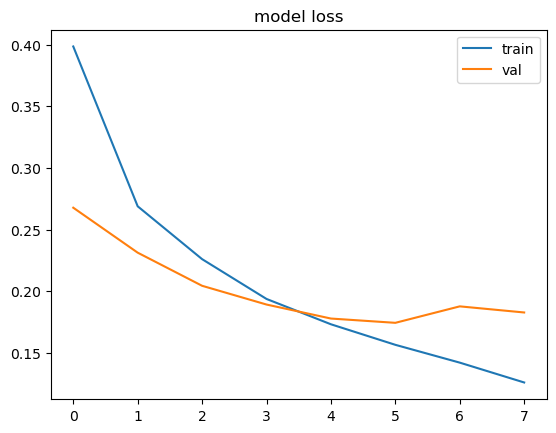

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.legend(['train', 'val'])
plt.title(f'model loss {label_number}')
plt.show()
print("loss\n",history1.history['loss'])
print("val loss\n",history1.history['val_loss'])

benchmark\
train log loss : 1.0316461173431106 \
valid log loss : 1.0560311513842007 \
sample predictions below

In [38]:
# for i in range (10):
#     sample_matrix, sample_label= create_matrix(np.random.randint(809)) ## 0.2 second # max = 808
#     print (f"{i+1}th prediction")
#     print("prediction : ",(model1.predict(sample_matrix.reshape(-1, 2650,1350,1),verbose = 0)).squeeze())
#     print("true label : ",np.array(sample_label))

## 5. Predictions
<ul>
<li>prediction of total 312 samples</li>
<li>merging predictions from all model</li>
<li>summerizing each model loss</li>
</ul>